# Step 1: Set up the Environment


In [18]:
!pip install tensorflow

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, utils, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# Step 2: Load the Data


In [20]:
# Load CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

n = 50000
train_images = train_images[:n]
train_labels = train_labels[:n]

In [22]:
# Print shapes and number of classes for reference
print("The shape of the training images is: ", train_images.shape)
print("The shape of the training labels is: ", train_labels.shape)
print("The shape of the test images is: ", test_images.shape)
print("The shape of the test labels is: ", test_labels.shape)
print("The type of the training images is: ", train_images.dtype)
print("The size of every image is: ", train_images.shape[1:])
num_classes = len(np.unique(train_labels))
print("The number of classes is: ", num_classes)

The shape of the training images is:  (50000, 32, 32, 3)
The shape of the training labels is:  (50000, 1)
The shape of the test images is:  (10000, 32, 32, 3)
The shape of the test labels is:  (10000, 1)
The type of the training images is:  uint8
The size of every image is:  (32, 32, 3)
The number of classes is:  10


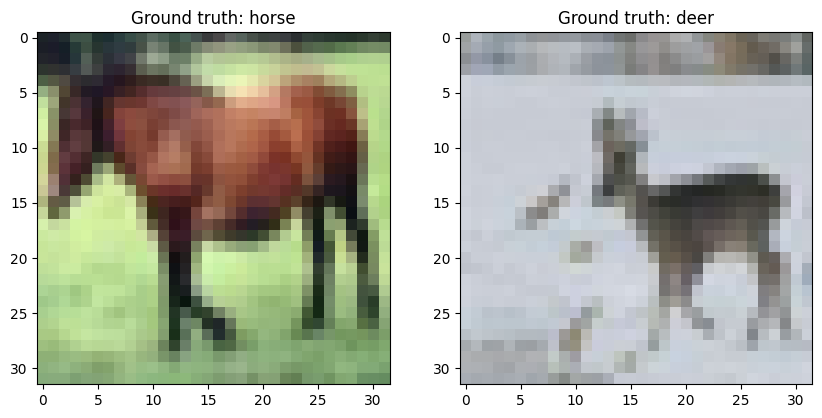

In [23]:
# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot sample images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(train_images[7])  # CIFAR-10 images are already RGB
ax1.set_title(f"Ground truth: {class_names[int(train_labels[7])]}")
ax2.imshow(train_images[20])
ax2.set_title(f"Ground truth: {class_names[int(train_labels[20])]}")
plt.show()

# Step 3: Data Preprocessing

In [24]:
# Normalize the pixel values of the images to the range [0, 1]
# Dividing by 255.0 converts the pixel values from the range [0, 255] to [0, 1].
# The images are also cast to the "float32" data type for better performance during model training.
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# The 'to_categorical' function converts the integer class labels into one-hot encoded vectors.
# This is required because the model's output layer has a softmax activation, which produces probabilities for each class.
# Categorical cross-entropy loss expects the target labels in one-hot encoded format for multi-class classification tasks.
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Step 4: CNN Architecture

In [25]:
# Create a custom CNN model
model = models.Sequential([
    # First Conv2D layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),  # Max pooling to reduce spatial dimensions

    # Second Conv2D layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),  # Max pooling layer

    # Third Conv2D layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),  # Max pooling layer

    # Flatten the feature maps for the fully connected layer
    layers.Flatten(),

    # Second Dense layer (new one)
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),

    # Fully connected layer
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    # Dropout layer to reduce overfitting
    layers.Dropout(0.5),

    # Output layer for 10 classes (softmax for multi-class classification)
    layers.Dense(10, activation='softmax')
])

# Step 5: Compile the Model

In [26]:
# Label smoothing is applied to reduce the model's confidence on predictions, which can help prevent overfitting.
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Compile the model
# Adam is an adaptive optimizer that adjusts learning rates during training for faster convergence.
# We use 'accuracy' as the metric to evaluate the model's performance during training.
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=loss_fn,  # Using the previously defined loss function with label smoothing
    metrics=['accuracy']
)

In [27]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 652,106 (2.49 MB)

 Trainable params: 652,042 (2.49 MB)

 Non-trainable params: 64 (256.00 B)

# Step 6: Train the Model

In [28]:
# Define callbacks to stop early and reduce learning rate on plateaus
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

In [29]:
# Train the model
history = model.fit(
    train_images, train_labels,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 136s 107ms/step - accuracy: 0.2179 - loss: 6.2367 - val_accuracy: 0.4794 - val_loss: 2.9452 - learning_rate: 1.0000e-04
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 130s 104ms/step - accuracy: 0.4283 - loss: 2.7722 - val_accuracy: 0.5516 - val_loss: 2.0680 - learning_rate: 1.0000e-04
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.5124 - loss: 2.0667 - val_accuracy: 0.6034 - val_loss: 1.7336 - learning_rate: 1.0000e-04
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.5680 - loss: 1.7664 - val_accuracy: 0.6372 - val_loss: 1.5584 - learning_rate: 1.0000e-04
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.6168 - loss: 1.5982 - val_accuracy: 0.6715 - val_loss: 1.4451 - learning_rate: 1.0000e-04
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.6526 - loss: 1.5040 - val_accuracy: 0.6845 - val_loss: 1.3802 - learning_rate: 1.0000e-04
Epoch 7/15
1250/1250 ━━━━━━━

In [30]:
# Evaluate model performance on test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy before finetune: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7440 - loss: 1.2284
Test accuracy before finetune: 0.7423


# Step 7: Finetune the Model

In [31]:
# Compile the model again (use a lower learning rate)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model again
history_finetune = model.fit(
    train_images, train_labels,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 132s 104ms/step - accuracy: 0.7849 - loss: 0.8845 - val_accuracy: 0.7575 - val_loss: 0.8692 - learning_rate: 1.0000e-06
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.7821 - loss: 0.8275 - val_accuracy: 0.7581 - val_loss: 0.8539 - learning_rate: 1.0000e-06
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.7863 - loss: 0.8154 - val_accuracy: 0.7598 - val_loss: 0.8480 - learning_rate: 1.0000e-06
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.7854 - loss: 0.8106 - val_accuracy: 0.7593 - val_loss: 0.8444 - learning_rate: 1.0000e-06
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.7850 - loss: 0.8087 - val_accuracy: 0.7590 - val_loss: 0.8418 - learning_rate: 1.0000e-06
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 104ms/step - accuracy: 0.7874 - loss: 0.8026 - val_accuracy: 0.7594 - val_loss: 0.8402 - learning_rate: 1.0000e-06
Epoch 7/15
1250/1250 ━━━━━━━

# Step 8: Evaluate the Model

In [32]:
# Evaluate model performance on test set after fine-tuning
test_loss_finetune, test_acc_finetune = model.evaluate(test_images, test_labels)
print(f"Test accuracy after fine-tuning: {test_acc_finetune:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7624 - loss: 0.8345
Test accuracy after fine-tuning: 0.7560


# Step 9: Plot Accuracy & Loss Curves

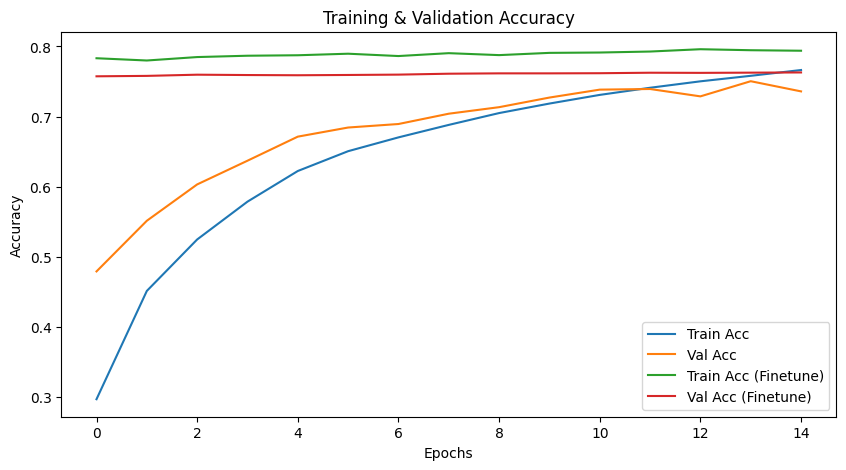

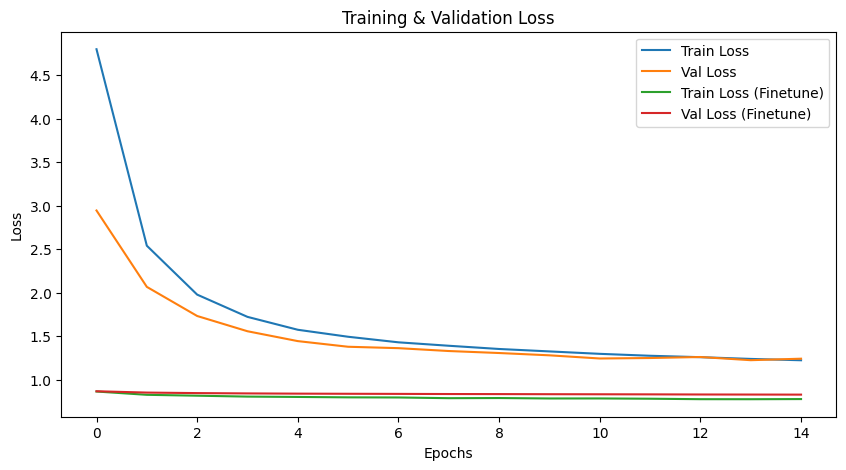

In [33]:
# Plot accuracy curve
plt.figure(figsize=[10,5])
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history_finetune.history['accuracy'], label='Train Acc (Finetune)')
plt.plot(history_finetune.history['val_accuracy'], label='Val Acc (Finetune)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

# Plot loss curve
plt.figure(figsize=[10,5])
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history_finetune.history['loss'], label='Train Loss (Finetune)')
plt.plot(history_finetune.history['val_loss'], label='Val Loss (Finetune)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# Step 10: Evaluating Model Performance: Classification Report and Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
              precision    recall  f1-score   support

    airplane       0.78      0.79      0.79      1000
  automobile       0.87      0.86      0.87      1000
        bird       0.67      0.65      0.66      1000
         cat       0.58      0.56      0.57      1000
        deer       0.69      0.71      0.70      1000
         dog       0.67      0.65      0.66      1000
        frog       0.80      0.84      0.82      1000
       horse       0.80      0.81      0.80      1000
        ship       0.85      0.87      0.86      1000
       truck       0.83      0.83      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.75      0.76      0.76     10000
weighted avg       0.75      0.76      0.76     10000



<Figure size 1000x800 with 0 Axes>

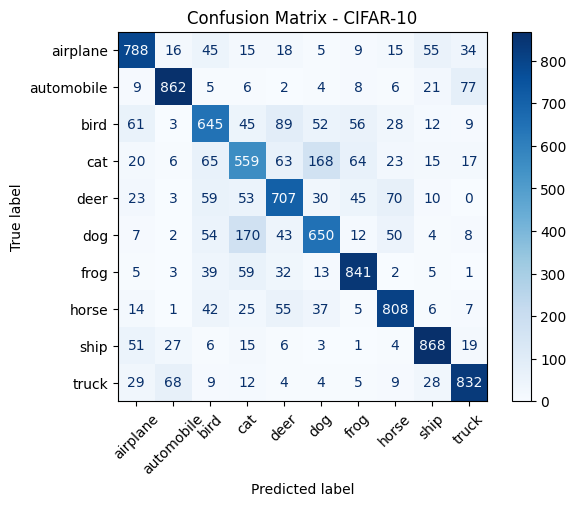

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities
predictions = model.predict(test_images)

# Convert to class labels
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - CIFAR-10")
plt.show()